Imports and Initialization

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.compat.v1.enable_eager_execution()


Define Activation Function

In [2]:
def tanh(x):
    return tf.tanh(x)

Define Forward Propagation

In [3]:
@tf.function
def forwardPropagation(inputs, weights, biases):
    x, t = inputs[:, 0:1], inputs[:, 1:2]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)

        inputLayer = tf.concat([x, t], axis=1)

        layer1 = tanh(tf.matmul(inputLayer, weights['w1']) + biases['b1'])
        layer2 = tanh(tf.matmul(layer1, weights['w2']) + biases['b2'])
        layer3 = tanh(tf.matmul(layer2, weights['w3']) + biases['b3'])
        outputLayer = tf.matmul(layer3, weights['w4']) + biases['b4']

        u1, u2, u3 = outputLayer[:, 0:1], outputLayer[:, 1:2], outputLayer[:, 2:3]

        u1_x = tape.gradient(u1, x)
        u2_x = tape.gradient(u2, x)

    u1_xx = tape.gradient(u1_x, x)
    u2_xx = tape.gradient(u2_x, x)
    u1_t = tape.gradient(u1, t)
    u2_t = tape.gradient(u2, t)

    return u1, u2, u3, u1_x, u2_x, u1_xx, u2_xx, u1_t, u2_t


Hyperparameters and Initializations

In [4]:
# Hyperparameters
epochs = 10000
initial_learning_rate = 1e-3
batch_size = 1000

initializer = tf.keras.initializers.GlorotUniform()

weights = {
    'w1': tf.Variable(initializer([2, 64])),
    'w2': tf.Variable(initializer([64, 64])),
    'w3': tf.Variable(initializer([64, 32])),
    'w4': tf.Variable(initializer([32, 3]))
}

biases = {
    'b1': tf.Variable(tf.zeros([64])),
    'b2': tf.Variable(tf.zeros([64])),
    'b3': tf.Variable(tf.zeros([32])),
    'b4': tf.Variable(tf.zeros([3]))
}

optimizer = tf.optimizers.Adam(learning_rate=initial_learning_rate)


Define Training Step

In [5]:
@tf.function
def train_step(x_batch, t_batch):
    inputs = tf.concat([x_batch, t_batch], axis=1)
    with tf.GradientTape() as tape:
        u1, u2, u3, u1_x, u2_x, u1_xx, u2_xx, u1_t, u2_t = forwardPropagation(inputs, weights, biases)

        f1 = u1_t - u1_xx - u3 * tf.sin(np.pi * x_batch)
        f2 = u2_t - u2_xx - u3 * tf.cos(np.pi * x_batch)
        f3 = u1 * tf.sin(np.pi * x_batch) + u2 * tf.cos(np.pi * x_batch) - tf.exp(-t_batch)

        loss_pde = tf.reduce_mean(tf.square(f1) + tf.square(f2) + tf.square(f3))

        inputs_ic = tf.concat([x_batch, tf.zeros_like(x_batch)], axis=1)
        u1_ic, u2_ic, u3_ic, _, _, _, _, _, _ = forwardPropagation(inputs_ic, weights, biases)
        ic1 = u1_ic - tf.sin(np.pi * x_batch)
        ic2 = u2_ic - tf.cos(np.pi * x_batch)

        loss_ic = tf.reduce_mean(tf.square(ic1) + tf.square(ic2))

        loss = loss_pde + loss_ic

    gradients = tape.gradient(loss, list(weights.values()) + list(biases.values()))
    optimizer.apply_gradients(zip(gradients, list(weights.values()) + list(biases.values())))
    return loss, loss_pde, loss_ic


Training Loop

In [6]:
# Training loop
for epoch in range(epochs):
    x_batch = tf.random.uniform([batch_size, 1], minval=0, maxval=1, dtype=tf.float32)
    t_batch = tf.random.uniform([batch_size, 1], minval=0, maxval=1, dtype=tf.float32)
    
    loss, loss_pde, loss_ic = train_step(x_batch, t_batch)
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy():.4e}, PDE Loss: {loss_pde.numpy():.4e}, IC Loss: {loss_ic.numpy():.4e}')


Epoch 0, Loss: 1.6160e+00, PDE Loss: 6.1411e-01, IC Loss: 1.0019e+00
Epoch 1000, Loss: 7.9814e-03, PDE Loss: 2.9170e-03, IC Loss: 5.0644e-03
Epoch 2000, Loss: 1.2092e-03, PDE Loss: 8.6556e-04, IC Loss: 3.4369e-04
Epoch 3000, Loss: 9.2521e-04, PDE Loss: 7.7746e-04, IC Loss: 1.4775e-04
Epoch 4000, Loss: 4.0751e-04, PDE Loss: 2.7627e-04, IC Loss: 1.3124e-04
Epoch 5000, Loss: 6.6702e-04, PDE Loss: 5.5614e-04, IC Loss: 1.1088e-04
Epoch 6000, Loss: 2.6812e-04, PDE Loss: 1.6320e-04, IC Loss: 1.0492e-04
Epoch 7000, Loss: 2.5528e-04, PDE Loss: 1.6136e-04, IC Loss: 9.3919e-05
Epoch 8000, Loss: 2.4791e-04, PDE Loss: 1.6346e-04, IC Loss: 8.4447e-05
Epoch 9000, Loss: 4.4064e-04, PDE Loss: 3.7254e-04, IC Loss: 6.8095e-05


Test the Model

In [7]:
# Test the model
x_data = np.linspace(0, 1, num=50)
t_data = np.linspace(0, 1, num=50)
test_x, test_t = np.meshgrid(x_data, t_data)
test_domain = np.stack([test_x.ravel(), test_t.ravel()], axis=-1)
test_domain_tf = tf.convert_to_tensor(test_domain, dtype=tf.float32)

predicted_solution = forwardPropagation(test_domain_tf, weights, biases)[:3]
predicted_solution = [p.numpy().reshape(test_x.shape) for p in predicted_solution]

analytical = [
    np.exp(-test_t) * np.sin(np.pi * test_x),
    np.exp(-test_t) * np.cos(np.pi * test_x),
    (1 + np.pi**2) * np.exp(-test_t)
]


Plot and Calculate Errors

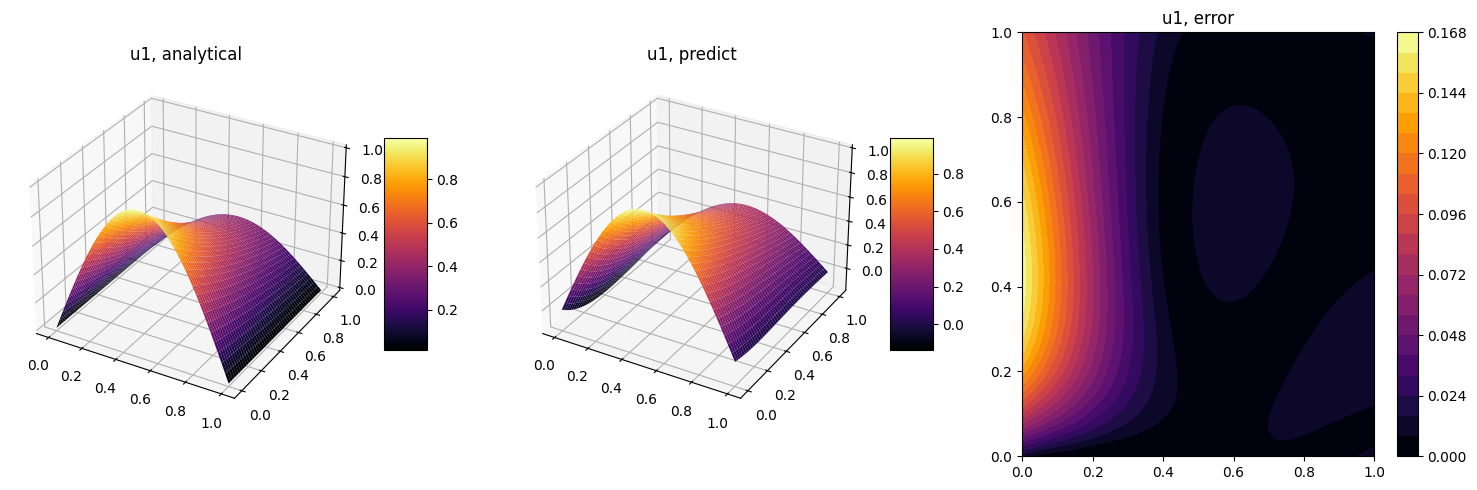

L2 relative error for u1: 1.0522e-01


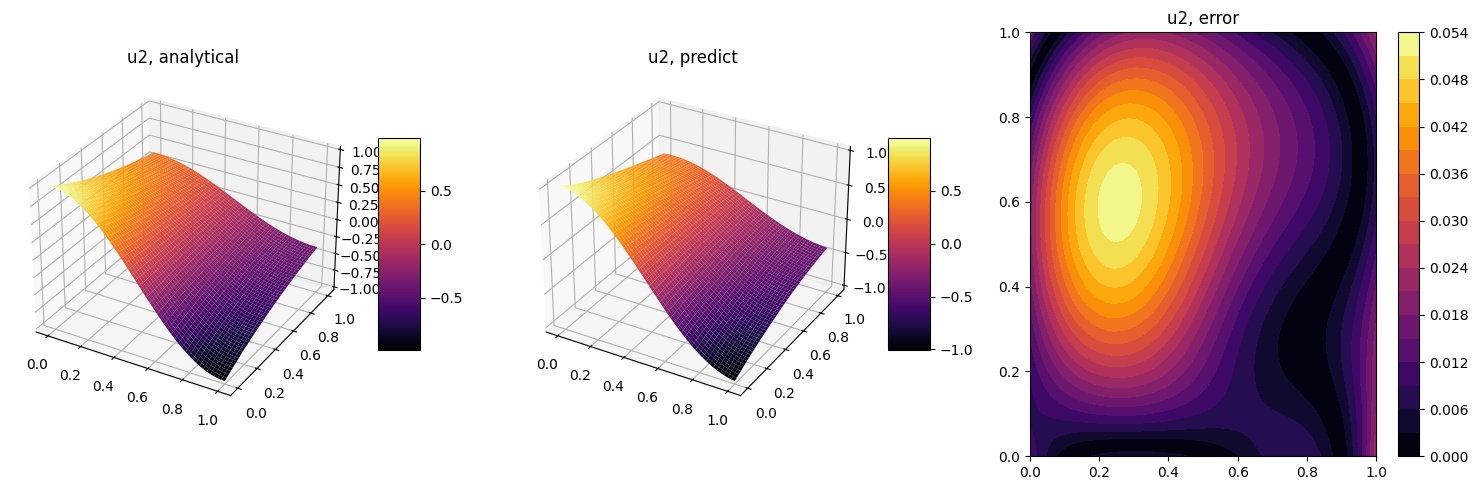

L2 relative error for u2: 5.2816e-02


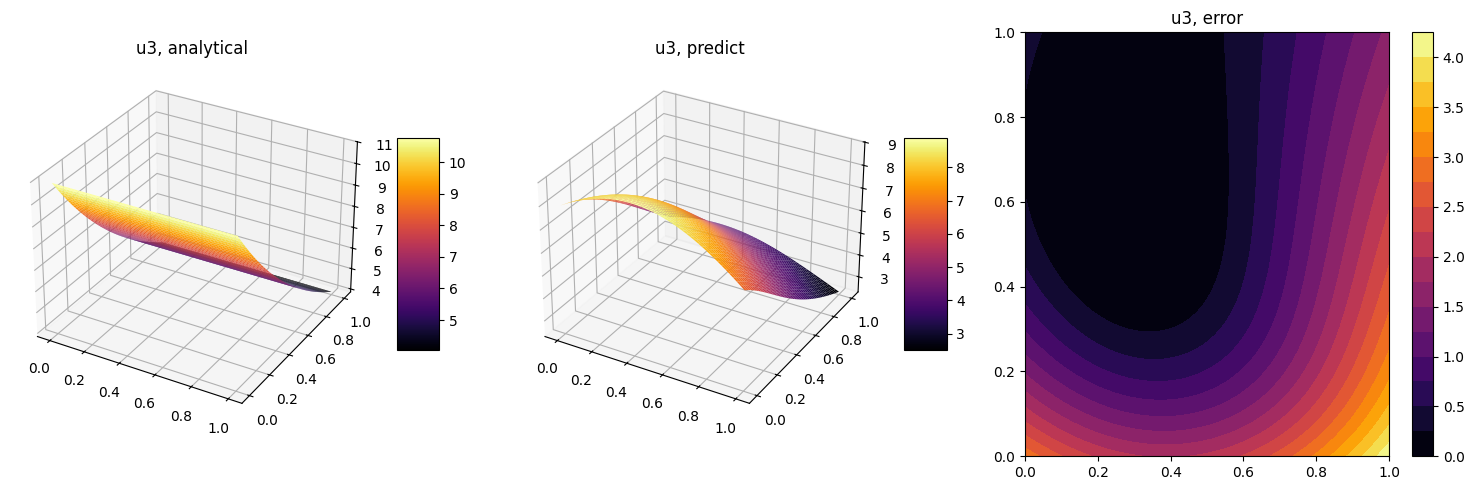

L2 relative error for u3: 1.7742e-01


In [8]:
# Plot and calculate errors
for i in range(3):
    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.set_title(f"u{i+1}, analytical")
    surf = ax.plot_surface(test_x, test_t, analytical[i], cmap='inferno')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.set_title(f"u{i+1}, predict")
    surf = ax.plot_surface(test_x, test_t, predicted_solution[i], cmap='inferno')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title(f"u{i+1}, error")
    im = ax.contourf(test_x, test_t, np.abs(analytical[i] - predicted_solution[i]), cmap='inferno', levels=20)
    fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

    l2_error = np.linalg.norm(analytical[i] - predicted_solution[i]) / np.linalg.norm(analytical[i])
    print(f"L2 relative error for u{i+1}: {l2_error:.4e}")
